# Generic HMC 

### Imports

In [14]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as _l2hmc
from l2hmc_eager import gauge_dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import GMM, gen_ring
from utils.jacobian import _map, jacobian
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

from HMC.hmc import HMC

from lattice.gauge_lattice import GaugeLattice, pbc, mat_adj, u1_plaq_exact

%autoreload 2

In [1]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

Using TensorFlow backend.


In [17]:
def train_one_iter(dynamics, x, optimizer, loss_fn=l2hmc.compute_loss, 
                   scale=0.1, eps=1e-4, l2_dist=True, global_step=None):
    loss, grads, out, accept_prob = l2hmc.loss_and_grads(
        dynamics, x, loss_fn=loss_fn, scale=scale, eps=eps, l2_dist=l2_dist
    )
    gradients, _ = tf.clip_by_global_norm(grads, 10.)
    optimizer.apply_gradients(
        zip(grads, dynamics.trainable_variables), global_step=global_step
    )
    return loss, out, accept_prob

## 2D $U(1)$ Lattice Gauge Theory

In [131]:
time_size, space_size, dim, beta, num_samples = (8, 8, 2, 3.5, None)
link_type = 'U1'
lattice = GaugeLattice(time_size=time_size,
                       space_size=space_size,
                       dim=dim,
                       beta=beta,
                       link_type=link_type,
                       num_samples=num_samples, rand=False)
#samples = np.array([sample.flatten() for sample in lattice.samples])
lattice_energy_fn = lattice.get_energy_function()

In [133]:
step_size = 0.1
n_leapfrog_steps = 5 
#position_init = samples
position_init = lattice.links.flatten()
lattice_hmc = HMC(position_init=position_init,
                  step_size=step_size,
                  n_leapfrog_steps=n_leapfrog_steps,
                  potential_fn=lattice_energy_fn,
                  beta=lattice.beta)

In [134]:
# 500 steps in ~ 6m 41s
links0 = lattice.links.flatten()
momentum0 = np.random.randn(*links0.shape)
links_arr = [links0]
vel_arr = []
probs_arr = []
total_actions = []
average_plaquettes = []
topological_charges = []
links1 = links0
num_steps = 1000 
print('Exact value of the average plaquette '
      f'(at {beta}): {u1_plaq_exact(beta)}\n')

Exact value of the average plaquette (at 3.5): 0.8411037970508364



In [135]:
for i in range(num_steps):
    links1, vel1, probs1 = lattice_hmc.apply_transition(links1)
    
    observables = np.array(lattice._calc_plaq_observables(links1))
    _total_actions = observables[0]
    _avg_plaquettes = observables[1]
    _top_charges = observables[2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    print(f'\nstep: {i:<5g} accept rate: {np.mean(probs1):^8.5g}  '
      #f' time/step: {time.time() - t1:^6.4g} '
      f' avg_S: {np.mean(_total_actions):^8.5g} '
      f' avg_topQ: {np.mean(_top_charges):^8.5g} '
      f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')


step: 0     accept rate: 0.31972    avg_S:    0      avg_topQ:    0      avg_plaq:    1    
 

step: 1     accept rate:  0.2815    avg_S:    0      avg_topQ:    0      avg_plaq:    1    
 

step: 2     accept rate: 0.44943    avg_S:  21.003   avg_topQ: -0.017461  avg_plaq: 0.90623 
 

step: 3     accept rate: 0.79316    avg_S:  29.32    avg_topQ: 0.016189  avg_plaq: 0.86911 
 

step: 4     accept rate: 0.91462    avg_S:  32.193   avg_topQ: -0.033456  avg_plaq: 0.85628 
 

step: 5     accept rate:    1       avg_S:  34.104   avg_topQ: -0.15029  avg_plaq: 0.84775 
 

step: 6     accept rate:    1       avg_S:  28.541   avg_topQ: -0.0092433  avg_plaq: 0.87259 
 

step: 7     accept rate: 0.94729    avg_S:  27.461   avg_topQ: -0.06739  avg_plaq:  0.8774 
 

step: 8     accept rate: 0.78607    avg_S:  30.477   avg_topQ: -0.085952  avg_plaq: 0.86394 
 

step: 9     accept rate: 0.89615    avg_S:  35.494   avg_topQ: 0.011999  avg_plaq: 0.84154 
 

step: 10    accept rate:    1       avg_S:  


step: 86    accept rate: 0.74446    avg_S:  31.941   avg_topQ: -0.14236  avg_plaq: 0.85741 
 

step: 87    accept rate:    1       avg_S:  27.131   avg_topQ: 0.071346  avg_plaq: 0.87888 
 

step: 88    accept rate: 0.98378    avg_S:  29.192   avg_topQ: -0.046861  avg_plaq: 0.86968 
 

step: 89    accept rate:  0.8116    avg_S:  36.847   avg_topQ: -0.074537  avg_plaq: 0.83551 
 

step: 90    accept rate: 0.90291    avg_S:  36.847   avg_topQ: -0.074537  avg_plaq: 0.83551 
 

step: 91    accept rate:    1       avg_S:  36.517   avg_topQ: 0.022781  avg_plaq: 0.83698 
 

step: 92    accept rate:    1       avg_S:  28.84    avg_topQ: -0.11544  avg_plaq: 0.87125 
 

step: 93    accept rate: 0.90258    avg_S:  32.225   avg_topQ: -0.0941   avg_plaq: 0.85614 
 

step: 94    accept rate:    1       avg_S:  26.37    avg_topQ: 0.028142  avg_plaq: 0.88228 
 

step: 95    accept rate:    1       avg_S:  28.641   avg_topQ: 0.039116  avg_plaq: 0.87214 
 

step: 96    accept rate: 0.88715    avg_S:  28


step: 172   accept rate:    1       avg_S:  34.677   avg_topQ: -0.012663  avg_plaq: 0.84519 
 

step: 173   accept rate:    1       avg_S:  28.163   avg_topQ: 0.080574  avg_plaq: 0.87427 
 

step: 174   accept rate:  0.6906    avg_S:  32.433   avg_topQ: 0.12051   avg_plaq: 0.85521 
 

step: 175   accept rate:    1       avg_S:  32.808   avg_topQ: -0.25639  avg_plaq: 0.85354 
 

step: 176   accept rate:    1       avg_S:  26.717   avg_topQ: -0.29593  avg_plaq: 0.88073 
 

step: 177   accept rate:    1       avg_S:  27.59    avg_topQ: 0.067165  avg_plaq: 0.87683 
 

step: 178   accept rate: 0.63018    avg_S:  27.59    avg_topQ: 0.067165  avg_plaq: 0.87683 
 

step: 179   accept rate: 0.90781    avg_S:  30.67    avg_topQ:  0.1368   avg_plaq: 0.86308 
 

step: 180   accept rate: 0.88529    avg_S:  34.204   avg_topQ: 0.049309  avg_plaq:  0.8473 
 

step: 181   accept rate: 0.81234    avg_S:  42.112   avg_topQ: -0.10989  avg_plaq:  0.812  
 

step: 182   accept rate:    1       avg_S:  35.3


step: 258   accept rate: 0.86647    avg_S:  34.738   avg_topQ: -0.093603  avg_plaq: 0.84492 
 

step: 259   accept rate: 0.88447    avg_S:  38.817   avg_topQ: -0.0034545  avg_plaq: 0.82671 
 

step: 260   accept rate:    1       avg_S:  27.669   avg_topQ: 0.01107   avg_plaq: 0.87648 
 

step: 261   accept rate: 0.74074    avg_S:  38.665   avg_topQ: -0.04925  avg_plaq: 0.82739 
 

step: 262   accept rate:    1       avg_S:  35.432   avg_topQ: 0.091014  avg_plaq: 0.84182 
 

step: 263   accept rate: 0.79145    avg_S:  44.781   avg_topQ: -0.11239  avg_plaq: 0.80009 
 

step: 264   accept rate: 0.93441    avg_S:  39.863   avg_topQ: -0.019046  avg_plaq: 0.82204 
 

step: 265   accept rate: 0.99549    avg_S:  42.721   avg_topQ: 0.093214  avg_plaq: 0.80928 
 

step: 266   accept rate: 0.99603    avg_S:  45.206   avg_topQ: 0.053342  avg_plaq: 0.79819 
 

step: 267   accept rate:    1       avg_S:  42.315   avg_topQ: -0.039924  avg_plaq: 0.81109 
 

step: 268   accept rate:    1       avg_S:  


step: 344   accept rate: 0.77957    avg_S:  38.967   avg_topQ: 0.13513   avg_plaq: 0.82604 
 

step: 345   accept rate:    1       avg_S:  32.918   avg_topQ: -0.11868  avg_plaq: 0.85305 
 

step: 346   accept rate: 0.65016    avg_S:  32.918   avg_topQ: -0.11868  avg_plaq: 0.85305 
 

step: 347   accept rate:    1       avg_S:  26.441   avg_topQ: 0.061967  avg_plaq: 0.88196 
 

step: 348   accept rate: 0.79308    avg_S:  33.528   avg_topQ: 0.071375  avg_plaq: 0.85032 
 

step: 349   accept rate:  0.466     avg_S:  33.528   avg_topQ: 0.071375  avg_plaq: 0.85032 
 

step: 350   accept rate: 0.54631    avg_S:  47.186   avg_topQ: 0.20266   avg_plaq: 0.78935 
 

step: 351   accept rate: 0.77318    avg_S:  61.654   avg_topQ: 0.066084  avg_plaq: 0.72476 
 

step: 352   accept rate:    1       avg_S:  41.021   avg_topQ: 0.02006   avg_plaq: 0.81687 
 

step: 353   accept rate:    1       avg_S:  38.747   avg_topQ: 0.080939  avg_plaq: 0.82702 
 

step: 354   accept rate: 0.98126    avg_S:  38.88


step: 430   accept rate: 0.85354    avg_S:  35.646   avg_topQ: -0.030418  avg_plaq: 0.84086 
 

step: 431   accept rate:    1       avg_S:  36.952   avg_topQ: -0.0065066  avg_plaq: 0.83504 
 

step: 432   accept rate:    1       avg_S:   23.1    avg_topQ: -0.024767  avg_plaq: 0.89688 
 

step: 433   accept rate:  0.7603    avg_S:  32.633   avg_topQ: -0.0026939  avg_plaq: 0.85432 
 

step: 434   accept rate: 0.79636    avg_S:  35.124   avg_topQ: -0.17024  avg_plaq:  0.8432 
 

step: 435   accept rate: 0.92216    avg_S:  39.057   avg_topQ: -0.11281  avg_plaq: 0.82564 
 

step: 436   accept rate:    1       avg_S:  34.552   avg_topQ: 0.026866  avg_plaq: 0.84575 
 

step: 437   accept rate:    1       avg_S:  26.656   avg_topQ: 0.038584  avg_plaq:  0.881  
 

step: 438   accept rate: 0.77198    avg_S:  34.506   avg_topQ: 0.024572  avg_plaq: 0.84596 
 

step: 439   accept rate:    1       avg_S:  28.872   avg_topQ: 0.015026  avg_plaq: 0.87111 
 

step: 440   accept rate:    1       avg_S: 


step: 516   accept rate: 0.66381    avg_S:  38.342   avg_topQ: -0.031326  avg_plaq: 0.82883 
 

step: 517   accept rate:    1       avg_S:  31.096   avg_topQ: -0.045099  avg_plaq: 0.86118 
 

step: 518   accept rate: 0.65556    avg_S:  47.176   avg_topQ: -0.057687  avg_plaq: 0.78939 
 

step: 519   accept rate: 0.96951    avg_S:  45.22    avg_topQ: 0.068448  avg_plaq: 0.79813 
 

step: 520   accept rate:    1       avg_S:  42.177   avg_topQ: -0.056926  avg_plaq: 0.81171 
 

step: 521   accept rate:    1       avg_S:  37.992   avg_topQ:  0.1575   avg_plaq: 0.83039 
 

step: 522   accept rate:    1       avg_S:  25.064   avg_topQ: -0.13215  avg_plaq: 0.88811 
 

step: 523   accept rate: 0.88869    avg_S:  30.53    avg_topQ: 0.10928   avg_plaq:  0.8637 
 

step: 524   accept rate: 0.69806    avg_S:  30.53    avg_topQ: 0.10928   avg_plaq:  0.8637 
 

step: 525   accept rate: 0.74818    avg_S:  37.678   avg_topQ: -0.14792  avg_plaq:  0.8318 
 

step: 526   accept rate:    1       avg_S:  2


step: 602   accept rate: 0.91082    avg_S:  32.964   avg_topQ: 0.05692   avg_plaq: 0.85284 
 

step: 603   accept rate:    1       avg_S:  31.452   avg_topQ: 0.072108  avg_plaq: 0.85959 
 

step: 604   accept rate:  0.8264    avg_S:  35.055   avg_topQ: -0.070398  avg_plaq:  0.8435 
 

step: 605   accept rate: 0.88981    avg_S:  40.411   avg_topQ: 0.0061781  avg_plaq: 0.81959 
 

step: 606   accept rate:    1       avg_S:  32.809   avg_topQ: 0.045772  avg_plaq: 0.85353 
 

step: 607   accept rate: 0.97032    avg_S:  33.387   avg_topQ: 0.035505  avg_plaq: 0.85095 
 

step: 608   accept rate: 0.81564    avg_S:  40.575   avg_topQ: 0.10517   avg_plaq: 0.81886 
 

step: 609   accept rate:    1       avg_S:  33.071   avg_topQ: 0.069265  avg_plaq: 0.85236 
 

step: 610   accept rate: 0.98819    avg_S:  37.43    avg_topQ: 0.04343   avg_plaq:  0.8329 
 

step: 611   accept rate: 0.67118    avg_S:  37.43    avg_topQ: 0.04343   avg_plaq:  0.8329 
 

step: 612   accept rate:  0.882     avg_S:  37.


step: 688   accept rate: 0.82249    avg_S:  41.093   avg_topQ: 0.14173   avg_plaq: 0.81655 
 

step: 689   accept rate:    1       avg_S:  37.001   avg_topQ: -0.10349  avg_plaq: 0.83482 
 

step: 690   accept rate:    1       avg_S:  30.867   avg_topQ: 0.013525  avg_plaq:  0.8622 
 

step: 691   accept rate:    1       avg_S:  31.151   avg_topQ: 0.081739  avg_plaq: 0.86093 
 

step: 692   accept rate:  0.7566    avg_S:  39.045   avg_topQ: -0.073031  avg_plaq: 0.82569 
 

step: 693   accept rate:    1       avg_S:  39.345   avg_topQ: 0.11738   avg_plaq: 0.82435 
 

step: 694   accept rate:    1       avg_S:  33.164   avg_topQ: -0.081804  avg_plaq: 0.85195 
 

step: 695   accept rate:    1       avg_S:  28.466   avg_topQ: 0.15784   avg_plaq: 0.87292 
 

step: 696   accept rate: 0.58544    avg_S:  44.229   avg_topQ: -0.022839  avg_plaq: 0.80255 
 

step: 697   accept rate:    1       avg_S:  32.564   avg_topQ: 0.0051129  avg_plaq: 0.85463 
 

step: 698   accept rate: 0.88595    avg_S:  3


step: 774   accept rate: 0.75714    avg_S:  35.279   avg_topQ: 0.096364  avg_plaq:  0.8425 
 

step: 775   accept rate: 0.88366    avg_S:  38.737   avg_topQ: 0.021905  avg_plaq: 0.82707 
 

step: 776   accept rate: 0.70574    avg_S:  48.052   avg_topQ: 0.0097052  avg_plaq: 0.78548 
 

step: 777   accept rate:    1       avg_S:  40.014   avg_topQ: 0.00072901  avg_plaq: 0.82137 
 

step: 778   accept rate: 0.94708    avg_S:  42.051   avg_topQ: -0.091388  avg_plaq: 0.81227 
 

step: 779   accept rate:    1       avg_S:  35.479   avg_topQ: -0.049486  avg_plaq: 0.84161 
 

step: 780   accept rate:    1       avg_S:  36.041   avg_topQ: 0.055771  avg_plaq:  0.8391 
 

step: 781   accept rate: 0.86398    avg_S:  38.349   avg_topQ: -0.056404  avg_plaq:  0.8288 
 

step: 782   accept rate:    1       avg_S:  33.209   avg_topQ: 0.16827   avg_plaq: 0.85175 
 

step: 783   accept rate: 0.66235    avg_S:  44.579   avg_topQ:  0.3039   avg_plaq: 0.80099 
 

step: 784   accept rate:    1       avg_S: 


step: 860   accept rate: 0.87393    avg_S:  36.113   avg_topQ: 0.069224  avg_plaq: 0.83878 
 

step: 861   accept rate:    1       avg_S:  37.687   avg_topQ: -0.16142  avg_plaq: 0.83175 
 

step: 862   accept rate: 0.65462    avg_S:  46.041   avg_topQ: 0.095139  avg_plaq: 0.79446 
 

step: 863   accept rate:    1       avg_S:  44.103   avg_topQ: -0.060325  avg_plaq: 0.80311 
 

step: 864   accept rate:    1       avg_S:  39.902   avg_topQ: -0.02749  avg_plaq: 0.82187 
 

step: 865   accept rate:    1       avg_S:  35.784   avg_topQ: -0.051042  avg_plaq: 0.84025 
 

step: 866   accept rate: 0.90217    avg_S:  35.697   avg_topQ: 0.073213  avg_plaq: 0.84064 
 

step: 867   accept rate: 0.79397    avg_S:  48.488   avg_topQ: 0.071758  avg_plaq: 0.78353 
 

step: 868   accept rate:    1       avg_S:  41.164   avg_topQ: 0.010647  avg_plaq: 0.81623 
 

step: 869   accept rate:    1       avg_S:  38.631   avg_topQ: 0.086742  avg_plaq: 0.82754 
 

step: 870   accept rate:    1       avg_S:  30.


step: 946   accept rate: 0.96287    avg_S:  35.65    avg_topQ: 0.070848  avg_plaq: 0.84085 
 

step: 947   accept rate: 0.85778    avg_S:  40.47    avg_topQ: -0.15427  avg_plaq: 0.81933 
 

step: 948   accept rate:    1       avg_S:  37.238   avg_topQ: 0.084516  avg_plaq: 0.83376 
 

step: 949   accept rate: 0.86751    avg_S:  44.777   avg_topQ: 0.095998  avg_plaq:  0.8001 
 

step: 950   accept rate:    1       avg_S:  45.23    avg_topQ: 0.091622  avg_plaq: 0.79808 
 

step: 951   accept rate: 0.92512    avg_S:  45.23    avg_topQ: 0.091622  avg_plaq: 0.79808 
 

step: 952   accept rate:    1       avg_S:  33.286   avg_topQ: -0.041249  avg_plaq:  0.8514 
 

step: 953   accept rate:    1       avg_S:  25.91    avg_topQ: -0.036637  avg_plaq: 0.88433 
 

step: 954   accept rate:  0.653     avg_S:  38.265   avg_topQ: -0.071255  avg_plaq: 0.82918 
 

step: 955   accept rate: 0.79294    avg_S:  47.746   avg_topQ:  0.1101   avg_plaq: 0.78685 
 

step: 956   accept rate:    1       avg_S:  42

In [136]:
np.mean(average_plaquettes)

0.8438221

In [52]:
print(u1_plaq_exact(beta))

0.8099852939565045


## Using L2HMC with auxiliary functions $Q, S, T \equiv 0$ (i.e. generic HMC)

In [42]:
##########################  Parameters  #####################################
# n_steps: number of leapfrog steps, eps: initial step size for dynamics
# loss_scale: scaling factor (lambda^2 in paper) in loss objective
# loss_eps: for numeric stability in loss function
# beta: inverse coupling strength
##############################################################################
time_size, space_size, dim, beta, num_samples = (4, 4, 2, 3., 4)
n_steps, eps, loss_scale, loss_eps = (10, 0.1, .1, 1e-4)
rand=True
l2_dist = True
conv_net = True

In [43]:
u1_lattice = GaugeLattice(time_size, space_size, dim, beta,
                          link_type='U1', num_samples=num_samples, rand=rand)
if conv_net:
    u1_samples_tensor = tf.convert_to_tensor(u1_lattice.samples, 
                                             dtype=tf.float32)
else:
    flat_samples = [sample.flatten() for sample in u1_lattice.samples]
    u1_samples_tensor = tf.convert_to_tensor(np.stack(flat_samples), 
                                             dtype=tf.float32)

# Construct dynamics object
u1_energy_fn = u1_lattice.get_energy_function(u1_samples_tensor)
u1_dynamics = l2hmc.GaugeDynamics(u1_lattice, n_steps=n_steps, eps=eps,
                                  minus_loglikelihood_fn=u1_energy_fn, 
                                  conv_net=conv_net, test_HMC=True)

In [44]:
global_step = tf.train.get_or_create_global_step()
_ = global_step.assign(1)
train_iters = 500
record_loss_every = 50
save_steps = 50 

learning_rate = tf.train.exponential_decay(1e-2, global_step, 50,
                                           0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
checkpointer = tf.train.Checkpoint(
    optimizer=optimizer, dynamics=u1_dynamics, global_step=global_step
)
#summary_writer = tf.contrib.summary.create_file_writer(log_dir)
loss_fn = l2hmc.compute_loss

print(u1_plaq_exact(beta))

0.8099852939565045


In [45]:
#################    Run L2HMC algorithm    ##################################
total_actions = []
average_plaquettes = []
topological_charges = []
samples = u1_samples_tensor

In [46]:
t0 = time.time()
start_step = global_step.numpy()
for i in range(start_step, 1000):
    t1 = time.time()
    loss, samples, accept_prob = train_one_iter(
        u1_dynamics,
        samples,
        optimizer,
        loss_fn=loss_fn,
        scale=loss_scale,
        eps=loss_eps,
        global_step=global_step
    )
    observables = np.array(u1_lattice.calc_plaq_observables(samples))
    _total_actions = observables[:, 0]
    _avg_plaquettes = observables[:, 1]
    _top_charges = observables[:, 2]
    
    total_actions.append(_total_actions)
    average_plaquettes.append(_avg_plaquettes)
    topological_charges.append(_top_charges)
    
    print(f'\nstep: {i:<5g} loss: {loss.numpy():^8.5g} '
          f' time/step: {time.time() - t1:^6.4g} '
          f' accept: {accept_prob.numpy().mean():^8.5g} '
          f' eps: {u1_dynamics.eps.numpy():^6.4g} '
          f' avg_S: {np.mean(_total_actions):^8.5g} '
          f' avg_topQ: {np.mean(_top_charges):^8.5g} '
          f' avg_plaq: {np.mean(_avg_plaquettes):^8.5g}\n ')
    print('avg_plaquettes: {}\n'.format([_avg_plaquettes]))


step: 1     loss: -7098.7   time/step: 26.09   accept:    1      eps:  0.09   avg_S:  36.647   avg_topQ: 0.60232   avg_plaq: 0.23653 
 
avg_plaquettes: [array([0.26164928, 0.22533642, 0.21960644, 0.23952486], dtype=float32)]


step: 2     loss:  -6986    time/step: 16.33   accept: 0.99642   eps: 0.0822  avg_S:  33.213   avg_topQ: 0.78447   avg_plaq: 0.30806 
 
avg_plaquettes: [array([0.20602147, 0.26986042, 0.3483461 , 0.40802214], dtype=float32)]


step: 3     loss: -5811.3   time/step: 16.48   accept: 0.99622   eps: 0.07352  avg_S:  20.518   avg_topQ:  1.4579   avg_plaq: 0.57253 
 
avg_plaquettes: [array([0.51545167, 0.5677755 , 0.5949156 , 0.6119882 ], dtype=float32)]


step: 4     loss: -6153.9   time/step: 15.56   accept:    1      eps: 0.06435  avg_S:  16.522   avg_topQ:   1.67    avg_plaq:  0.6558 
 
avg_plaquettes: [array([0.6064701 , 0.6690832 , 0.67988485, 0.6677588 ], dtype=float32)]


step: 5     loss: -7617.5   time/step: 16.24   accept: 0.99858   eps: 0.05504  avg_S:  13


step: 37    loss: -6643.5   time/step: 15.95   accept: 0.99254   eps: 0.02856  avg_S:  10.432   avg_topQ:  1.9931   avg_plaq: 0.78267 
 
avg_plaquettes: [array([0.7769519 , 0.74237853, 0.8133498 , 0.79801583], dtype=float32)]


step: 38    loss:  -6524    time/step: 16.69   accept: 0.99935   eps: 0.02696  avg_S:  7.4419   avg_topQ:  2.1517   avg_plaq: 0.84496 
 
avg_plaquettes: [array([0.7939288 , 0.89891493, 0.85834694, 0.82864726], dtype=float32)]


step: 39    loss: -5771.5   time/step: 16.49   accept: 0.99972   eps: 0.02514  avg_S:  7.3303   avg_topQ:  2.1576   avg_plaq: 0.84728 
 
avg_plaquettes: [array([0.8421362 , 0.9018861 , 0.830322  , 0.81479526], dtype=float32)]


step: 40    loss: -6949.6   time/step: 17.25   accept: 0.99625   eps: 0.02417  avg_S:  9.1105   avg_topQ:  2.0632   avg_plaq:  0.8102 
 
avg_plaquettes: [array([0.8192343 , 0.8735287 , 0.80106556, 0.7469603 ], dtype=float32)]


step: 41    loss:  -7083    time/step: 15.45   accept: 0.99825   eps: 0.0228  avg_S:  8


step: 74    loss: -6264.9   time/step: 20.04   accept: 0.99598   eps: 0.02641  avg_S:  9.176    avg_topQ:  2.0597   avg_plaq: 0.80883 
 
avg_plaquettes: [array([0.8125599 , 0.81832314, 0.76024485, 0.8442071 ], dtype=float32)]


step: 75    loss: -5738.3   time/step: 20.95   accept: 0.99841   eps: 0.02667  avg_S:  9.0749   avg_topQ:  2.065    avg_plaq: 0.81094 
 
avg_plaquettes: [array([0.8121878 , 0.8004028 , 0.83704853, 0.7941202 ], dtype=float32)]


step: 76    loss: -6457.7   time/step: 21.27   accept: 0.99886   eps: 0.02649  avg_S:  6.9313   avg_topQ:  2.1788   avg_plaq:  0.8556 
 
avg_plaquettes: [array([0.8854354 , 0.87184584, 0.79361373, 0.871498  ], dtype=float32)]


step: 77    loss: -6524.7   time/step: 20.02   accept: 0.99743   eps: 0.02729  avg_S:  7.7332   avg_topQ:  2.1362   avg_plaq: 0.83889 
 
avg_plaquettes: [array([0.83731645, 0.86944723, 0.8070905 , 0.8417162 ], dtype=float32)]


step: 78    loss: -6785.6   time/step: 19.15   accept:  0.9997   eps: 0.0268  avg_S:  6


step: 111   loss: -7812.7   time/step: 20.46   accept: 0.99637   eps: 0.03685  avg_S:  8.3877   avg_topQ:  2.1015   avg_plaq: 0.82526 
 
avg_plaquettes: [array([0.8567654 , 0.8703201 , 0.66971093, 0.9042302 ], dtype=float32)]


step: 112   loss: -6233.9   time/step: 21.33   accept: 0.99441   eps: 0.03635  avg_S:  7.8831   avg_topQ:  2.1283   avg_plaq: 0.83577 
 
avg_plaquettes: [array([0.8575568 , 0.81682223, 0.80018634, 0.86851096], dtype=float32)]


step: 113   loss: -7001.6   time/step: 19.71   accept:  0.9986   eps: 0.0362  avg_S:  6.9178   avg_topQ:  2.1795   avg_plaq: 0.85588 
 
avg_plaquettes: [array([0.9132592, 0.8263965, 0.8028764, 0.8809851], dtype=float32)]


step: 114   loss: -6240.5   time/step: 21.28   accept: 0.98905   eps: 0.03578  avg_S:  7.5629   avg_topQ:  2.1453   avg_plaq: 0.84244 
 
avg_plaquettes: [array([0.7451977, 0.8638684, 0.9207034, 0.8399846], dtype=float32)]


step: 115   loss: -7009.7   time/step: 17.44   accept: 0.98025   eps: 0.03508  avg_S:  12.436   


step: 148   loss: -7764.5   time/step: 19.42   accept:  0.9993   eps: 0.01493  avg_S:  9.2675   avg_topQ:  2.0548   avg_plaq: 0.80693 
 
avg_plaquettes: [array([0.81544065, 0.8001665 , 0.8092253 , 0.8028746 ], dtype=float32)]


step: 149   loss: -5892.6   time/step: 20.32   accept: 0.99953   eps: 0.01607  avg_S:  8.936    avg_topQ:  2.0724   avg_plaq: 0.81383 
 
avg_plaquettes: [array([0.7742995 , 0.8190799 , 0.8463097 , 0.81564313], dtype=float32)]


step: 150   loss: -6983.7   time/step: 19.39   accept: 0.99991   eps: 0.01731  avg_S:  7.9833   avg_topQ:  2.123    avg_plaq: 0.83368 
 
avg_plaquettes: [array([0.7646808 , 0.8551904 , 0.8767388 , 0.83811396], dtype=float32)]


step: 151   loss: -7364.3   time/step: 18.32   accept:  0.999    eps: 0.01846  avg_S:  7.4117   avg_topQ:  2.1533   avg_plaq: 0.84559 
 
avg_plaquettes: [array([0.75474215, 0.8809035 , 0.94393116, 0.80278426], dtype=float32)]


step: 152   loss: -6975.1   time/step: 18.54   accept: 0.99723   eps: 0.02104  avg_S:  


step: 185   loss: -6457.3   time/step: 18.71   accept: 0.99981   eps: 0.0131  avg_S:  7.8777   avg_topQ:  2.1286   avg_plaq: 0.83588 
 
avg_plaquettes: [array([0.84728456, 0.84201396, 0.7922384 , 0.8619883 ], dtype=float32)]


step: 186   loss: -6915.3   time/step: 22.63   accept: 0.99899   eps: 0.01174  avg_S:  8.7859   avg_topQ:  2.0804   avg_plaq: 0.81696 
 
avg_plaquettes: [array([0.8467    , 0.7692575 , 0.78381354, 0.86807454], dtype=float32)]


step: 187   loss: -6291.1   time/step: 18.19   accept: 0.99971   eps: 0.01042  avg_S:  8.8545   avg_topQ:  2.0767   avg_plaq: 0.81553 
 
avg_plaquettes: [array([0.81772214, 0.78156936, 0.75807345, 0.9047584 ], dtype=float32)]


step: 188   loss: -6683.9   time/step: 18.95   accept: 0.99976   eps: 0.008916  avg_S:  9.2093   avg_topQ:  2.0579   avg_plaq: 0.80814 
 
avg_plaquettes: [array([0.83054423, 0.80202776, 0.75773406, 0.84225005], dtype=float32)]


step: 189   loss: -6600.7   time/step: 20.72   accept: 0.99994   eps: 0.007608  avg_S: 


step: 222   loss: -7844.3   time/step: 22.96   accept:    1      eps: 0.02041  avg_S:  8.2647   avg_topQ:  2.108    avg_plaq: 0.82782 
 
avg_plaquettes: [array([0.80581254, 0.7390487 , 0.84111255, 0.92529905], dtype=float32)]


step: 223   loss: -6875.7   time/step: 21.63   accept:  0.9995   eps: 0.0226  avg_S:  7.8734   avg_topQ:  2.1288   avg_plaq: 0.83597 
 
avg_plaquettes: [array([0.7743167 , 0.8099466 , 0.86230224, 0.89731705], dtype=float32)]


step: 224   loss: -6764.1   time/step:  21.5   accept: 0.99702   eps: 0.0237  avg_S:  8.7234   avg_topQ:  2.0837   avg_plaq: 0.81826 
 
avg_plaquettes: [array([0.76374835, 0.86256915, 0.86242366, 0.7843054 ], dtype=float32)]


step: 225   loss: -6003.9   time/step: 20.42   accept: 0.99911   eps: 0.02508  avg_S:  8.5059   avg_topQ:  2.0952   avg_plaq: 0.82279 
 
avg_plaquettes: [array([0.7733489 , 0.806851  , 0.867712  , 0.84326154], dtype=float32)]


step: 226   loss: -6187.7   time/step: 17.67   accept: 0.99969   eps: 0.02661  avg_S:  7.


step: 258   loss: -5977.5   time/step: 17.65   accept:  0.9925   eps: 0.05391  avg_S:  7.0104   avg_topQ:  2.1746   avg_plaq: 0.85395 
 
avg_plaquettes: [array([0.9108919 , 0.7962164 , 0.8817988 , 0.82689106], dtype=float32)]


step: 259   loss: -6147.1   time/step: 19.02   accept: 0.97762   eps: 0.05582  avg_S:  10.952   avg_topQ:  1.9654   avg_plaq: 0.77182 
 
avg_plaquettes: [array([0.9146644, 0.6760815, 0.696718 , 0.7998348], dtype=float32)]


step: 260   loss: -5990.6   time/step: 26.16   accept: 0.99098   eps: 0.05639  avg_S:  9.6796   avg_topQ:  2.033    avg_plaq: 0.79834 
 
avg_plaquettes: [array([0.9146644 , 0.78845274, 0.6613562 , 0.82889163], dtype=float32)]


step: 261   loss: -7051.3   time/step: 18.43   accept: 0.98262   eps: 0.05671  avg_S:  9.7959   avg_topQ:  2.0268   avg_plaq: 0.79592 
 
avg_plaquettes: [array([0.7495765 , 0.83385146, 0.7757384 , 0.8245096 ], dtype=float32)]


step: 262   loss: -5745.3   time/step: 29.68   accept:  0.9887   eps: 0.05643  avg_S:  9.51


step: 295   loss:  -6796    time/step: 23.16   accept: 0.99511   eps: 0.0351  avg_S:  9.3125   avg_topQ:  2.0524   avg_plaq: 0.80599 
 
avg_plaquettes: [array([0.7693935 , 0.89050555, 0.75173813, 0.81232405], dtype=float32)]


step: 296   loss: -7290.6   time/step: 24.61   accept:  0.9976   eps: 0.03675  avg_S:  7.3827   avg_topQ:  2.1548   avg_plaq: 0.84619 
 
avg_plaquettes: [array([0.82288307, 0.8282539 , 0.83332217, 0.90031624], dtype=float32)]


step: 297   loss: -6850.7   time/step: 25.23   accept:  0.9972   eps: 0.03824  avg_S:  5.8265   avg_topQ:  2.2374   avg_plaq: 0.87862 
 
avg_plaquettes: [array([0.91106534, 0.88758016, 0.8476171 , 0.86819893], dtype=float32)]


step: 298   loss: -6750.7   time/step: 23.99   accept: 0.99453   eps: 0.04017  avg_S:  7.0289   avg_topQ:  2.1736   avg_plaq: 0.85356 
 
avg_plaquettes: [array([0.94031656, 0.8836518 , 0.7810677 , 0.8092182 ], dtype=float32)]


step: 299   loss: -6697.3   time/step: 27.12   accept: 0.99352   eps: 0.04208  avg_S:  8


step: 331   loss: -6119.6   time/step:   19    accept: 0.99862   eps: 0.02029  avg_S:  8.0043   avg_topQ:  2.1218   avg_plaq: 0.83324 
 
avg_plaquettes: [array([0.8345848 , 0.9118101 , 0.74521255, 0.8413665 ], dtype=float32)]


step: 332   loss: -7462.9   time/step: 19.17   accept: 0.99869   eps: 0.02054  avg_S:  8.4095   avg_topQ:  2.1003   avg_plaq:  0.8248 
 
avg_plaquettes: [array([0.8823075 , 0.8453385 , 0.71365005, 0.8579104 ], dtype=float32)]


step: 333   loss: -6983.3   time/step: 19.16   accept: 0.99848   eps: 0.02019  avg_S:  8.3284   avg_topQ:  2.1046   avg_plaq: 0.82649 
 
avg_plaquettes: [array([0.8318254 , 0.8760413 , 0.76984036, 0.82826173], dtype=float32)]


step: 334   loss: -6525.5   time/step: 18.32   accept:  0.9988   eps: 0.01953  avg_S:  8.2242   avg_topQ:  2.1102   avg_plaq: 0.82866 
 
avg_plaquettes: [array([0.7768313 , 0.89866334, 0.7864087 , 0.85274905], dtype=float32)]


step: 335   loss: -8028.5   time/step:  17.8   accept: 0.99962   eps: 0.01873  avg_S:  


step: 368   loss:  -6815    time/step: 18.29   accept: 0.99599   eps: 0.03879  avg_S:  8.7392   avg_topQ:  2.0828   avg_plaq: 0.81793 
 
avg_plaquettes: [array([0.7326877, 0.9113901, 0.8242917, 0.8033607], dtype=float32)]


step: 369   loss: -6078.6   time/step: 17.68   accept: 0.98731   eps: 0.03801  avg_S:  10.782   avg_topQ:  1.9745   avg_plaq: 0.77538 
 
avg_plaquettes: [array([0.77040935, 0.85194016, 0.6731323 , 0.80605626], dtype=float32)]


step: 370   loss: -6591.5   time/step: 18.86   accept:    1      eps: 0.03846  avg_S:  8.9719   avg_topQ:  2.0705   avg_plaq: 0.81308 
 
avg_plaquettes: [array([0.82763195, 0.8379954 , 0.73921716, 0.8474946 ], dtype=float32)]


step: 371   loss: -7771.8   time/step: 18.59   accept: 0.99757   eps: 0.03957  avg_S:  7.3896   avg_topQ:  2.1544   avg_plaq: 0.84605 
 
avg_plaquettes: [array([0.7923578 , 0.87480253, 0.8309227 , 0.8861169 ], dtype=float32)]


step: 372   loss: -7282.8   time/step: 18.59   accept: 0.99078   eps: 0.03934  avg_S:  8.91


step: 405   loss: -5697.3   time/step: 20.44   accept: 0.99821   eps: 0.03546  avg_S:  8.6124   avg_topQ:  2.0896   avg_plaq: 0.82057 
 
avg_plaquettes: [array([0.8052167 , 0.75246763, 0.90322936, 0.82138467], dtype=float32)]


step: 406   loss: -6380.9   time/step: 18.41   accept: 0.99688   eps: 0.03594  avg_S:  7.2769   avg_topQ:  2.1604   avg_plaq:  0.8484 
 
avg_plaquettes: [array([0.8884296, 0.761339 , 0.867294 , 0.8765267], dtype=float32)]


step: 407   loss: -7021.7   time/step: 17.56   accept: 0.99242   eps: 0.0366  avg_S:  7.5281   avg_topQ:  2.1471   avg_plaq: 0.84317 
 
avg_plaquettes: [array([0.8043471 , 0.82200915, 0.81806576, 0.92823946], dtype=float32)]


step: 408   loss: -6468.3   time/step: 17.37   accept: 0.99739   eps: 0.03813  avg_S:  4.3645   avg_topQ:  2.3149   avg_plaq: 0.90907 
 
avg_plaquettes: [array([0.94198495, 0.9478936 , 0.87226135, 0.8741537 ], dtype=float32)]


step: 409   loss: -5584.6   time/step: 24.61   accept:  0.9852   eps: 0.03947  avg_S:  7.294


step: 442   loss: -7259.3   time/step: 24.17   accept: 0.98909   eps: 0.03837  avg_S:  8.8395   avg_topQ:  2.0775   avg_plaq: 0.81584 
 
avg_plaquettes: [array([0.8235971 , 0.86929834, 0.8908624 , 0.6796139 ], dtype=float32)]


step: 443   loss: -6901.6   time/step: 23.36   accept: 0.99233   eps: 0.03869  avg_S:  10.06    avg_topQ:  2.0128   avg_plaq: 0.79042 
 
avg_plaquettes: [array([0.82709885, 0.79058707, 0.7910213 , 0.752986  ], dtype=float32)]


step: 444   loss: -7029.5   time/step: 23.79   accept: 0.99736   eps: 0.03963  avg_S:  8.2011   avg_topQ:  2.1114   avg_plaq: 0.82914 
 
avg_plaquettes: [array([0.88782495, 0.88750434, 0.8005725 , 0.7406732 ], dtype=float32)]


step: 445   loss: -6338.9   time/step: 23.36   accept:  0.9801   eps: 0.04006  avg_S:  11.913   avg_topQ:  1.9145   avg_plaq: 0.75181 
 
avg_plaquettes: [array([0.78893685, 0.77745163, 0.9236315 , 0.5172033 ], dtype=float32)]


step: 446   loss:  -6031    time/step:  23.7   accept: 0.99429   eps: 0.04067  avg_S:  


step: 478   loss: -6405.1   time/step: 22.43   accept: 0.99996   eps: 0.006525  avg_S:  8.0687   avg_topQ:  2.1184   avg_plaq:  0.8319 
 
avg_plaquettes: [array([0.9070316 , 0.89072937, 0.6625575 , 0.86728597], dtype=float32)]


step: 479   loss: -6901.4   time/step: 19.86   accept: 0.99998   eps: 0.006803  avg_S:  7.6391   avg_topQ:  2.1412   avg_plaq: 0.84085 
 
avg_plaquettes: [array([0.9334306, 0.8999063, 0.6639118, 0.8661613], dtype=float32)]


step: 480   loss: -7195.6   time/step: 19.46   accept: 0.99987   eps: 0.007001  avg_S:  8.1738   avg_topQ:  2.1128   avg_plaq: 0.82971 
 
avg_plaquettes: [array([0.9186282 , 0.90475786, 0.66275877, 0.8327074 ], dtype=float32)]


step: 481   loss: -6289.7   time/step: 19.39   accept: 0.99996   eps: 0.006612  avg_S:  8.1603   avg_topQ:  2.1136   avg_plaq: 0.82999 
 
avg_plaquettes: [array([0.9096009 , 0.89371693, 0.6777059 , 0.83895135], dtype=float32)]


step: 482   loss: -5637.3   time/step: 20.45   accept: 0.99997   eps: 0.006884  avg_S: 


step: 514   loss: -6290.3   time/step: 20.49   accept: 0.99804   eps: 0.0214  avg_S:  6.6757   avg_topQ:  2.1923   avg_plaq: 0.86092 
 
avg_plaquettes: [array([0.7866017 , 0.8654488 , 0.90147185, 0.89016753], dtype=float32)]


step: 515   loss: -7101.1   time/step: 22.98   accept: 0.99801   eps: 0.02253  avg_S:  7.8302   avg_topQ:  2.1311   avg_plaq: 0.83687 
 
avg_plaquettes: [array([0.8205577 , 0.84060484, 0.8515942 , 0.83472294], dtype=float32)]


step: 516   loss: -6878.1   time/step:  23.1   accept: 0.99734   eps: 0.02413  avg_S:  8.6839   avg_topQ:  2.0858   avg_plaq: 0.81908 
 
avg_plaquettes: [array([0.85747546, 0.831979  , 0.7855737 , 0.80131173], dtype=float32)]


step: 517   loss:  -7099    time/step: 20.92   accept: 0.99893   eps: 0.02424  avg_S:  7.9924   avg_topQ:  2.1225   avg_plaq: 0.83349 
 
avg_plaquettes: [array([0.8471845, 0.8799053, 0.7901556, 0.8167208], dtype=float32)]


step: 518   loss: -7439.1   time/step: 21.55   accept: 0.99812   eps: 0.02536  avg_S:  6.691


step: 550   loss: -7400.7   time/step: 15.96   accept: 0.99689   eps: 0.02416  avg_S:  11.356   avg_topQ:  1.944    avg_plaq: 0.76342 
 
avg_plaquettes: [array([0.5108602 , 0.84869653, 0.8790506 , 0.81508815], dtype=float32)]


step: 551   loss: -6568.4   time/step: 15.49   accept: 0.99859   eps: 0.01904  avg_S:  11.05    avg_topQ:  1.9602   avg_plaq: 0.76978 
 
avg_plaquettes: [array([0.5074372 , 0.8030435 , 0.90942943, 0.85922927], dtype=float32)]


step: 552   loss: -5224.2   time/step: 16.48   accept: 0.99973   eps: 0.01494  avg_S:  9.4863   avg_topQ:  2.0432   avg_plaq: 0.80237 
 
avg_plaquettes: [array([0.59358275, 0.8162901 , 0.8992111 , 0.90039194], dtype=float32)]


step: 553   loss: -6151.6   time/step: 15.76   accept: 0.99932   eps: 0.01064  avg_S:  9.8551   avg_topQ:  2.0236   avg_plaq: 0.79469 
 
avg_plaquettes: [array([0.6860169, 0.7956164, 0.8557447, 0.8413633], dtype=float32)]


step: 554   loss: -6821.4   time/step: 17.29   accept: 0.99997   eps: 0.007239  avg_S:  9.1


step: 587   loss: -6394.5   time/step: 13.78   accept:  0.9892   eps: 0.08094  avg_S:  8.4685   avg_topQ:  2.0972   avg_plaq: 0.82357 
 
avg_plaquettes: [array([0.78784114, 0.7921005 , 0.87949985, 0.83485407], dtype=float32)]


step: 588   loss: -6590.2   time/step: 13.68   accept: 0.99656   eps: 0.07996  avg_S:  8.2992   avg_topQ:  2.1062   avg_plaq:  0.8271 
 
avg_plaquettes: [array([0.83614695, 0.74984634, 0.89697695, 0.82542664], dtype=float32)]


step: 589   loss: -8375.8   time/step: 13.73   accept: 0.98569   eps: 0.07875  avg_S:  8.2171   avg_topQ:  2.1105   avg_plaq: 0.82881 
 
avg_plaquettes: [array([0.85853183, 0.8560999 , 0.80489564, 0.79571456], dtype=float32)]


step: 590   loss:  -7283    time/step: 14.21   accept: 0.99398   eps: 0.07754  avg_S:  7.4913   avg_topQ:  2.1491   avg_plaq: 0.84393 
 
avg_plaquettes: [array([0.85812724, 0.8297739 , 0.8526301 , 0.8351949 ], dtype=float32)]


step: 591   loss: -6464.6   time/step: 13.57   accept:    1      eps: 0.07622  avg_S:  


step: 624   loss: -6796.5   time/step: 21.26   accept: 0.98828   eps: 0.03632  avg_S:  10.89    avg_topQ:  1.9688   avg_plaq: 0.77313 
 
avg_plaquettes: [array([0.733042  , 0.75374407, 0.82812697, 0.7776027 ], dtype=float32)]


step: 625   loss: -6066.3   time/step: 22.19   accept: 0.99453   eps: 0.03576  avg_S:  10.143   avg_topQ:  2.0084   avg_plaq: 0.78869 
 
avg_plaquettes: [array([0.8213987 , 0.69429946, 0.8030219 , 0.8360455 ], dtype=float32)]


step: 626   loss: -7630.3   time/step: 20.78   accept: 0.99976   eps: 0.03501  avg_S:  9.6909   avg_topQ:  2.0324   avg_plaq: 0.79811 
 
avg_plaquettes: [array([0.81975585, 0.7697885 , 0.77901775, 0.8238596 ], dtype=float32)]


step: 627   loss:  -6564    time/step: 17.33   accept: 0.99533   eps: 0.03439  avg_S:  8.1681   avg_topQ:  2.1131   avg_plaq: 0.82983 
 
avg_plaquettes: [array([0.91968036, 0.6486063 , 0.82182974, 0.92920536], dtype=float32)]


step: 628   loss: -6033.9   time/step: 17.68   accept: 0.99297   eps: 0.03364  avg_S:  


step: 661   loss: -6114.9   time/step: 14.89   accept: 0.99821   eps: 0.02912  avg_S:  9.6067   avg_topQ:  2.0368   avg_plaq: 0.79986 
 
avg_plaquettes: [array([0.7640574 , 0.7922576 , 0.78942895, 0.8536961 ], dtype=float32)]


step: 662   loss: -6049.8   time/step: 14.13   accept: 0.99738   eps: 0.02893  avg_S:  9.0349   avg_topQ:  2.0672   avg_plaq: 0.81177 
 
avg_plaquettes: [array([0.85829175, 0.7422458 , 0.73419845, 0.91235566], dtype=float32)]


step: 663   loss: -6827.2   time/step: 14.44   accept: 0.99429   eps: 0.0288  avg_S:  8.1408   avg_topQ:  2.1146   avg_plaq:  0.8304 
 
avg_plaquettes: [array([0.86675686, 0.83835   , 0.81496847, 0.80152404], dtype=float32)]


step: 664   loss: -6746.9   time/step: 14.48   accept: 0.99809   eps: 0.02873  avg_S:  7.791    avg_topQ:  2.1332   avg_plaq: 0.83769 
 
avg_plaquettes: [array([0.893207  , 0.81421864, 0.75333124, 0.8899904 ], dtype=float32)]


step: 665   loss: -6543.8   time/step: 15.66   accept: 0.99586   eps: 0.02883  avg_S:  9


step: 697   loss: -6845.9   time/step: 13.97   accept: 0.99843   eps: 0.02079  avg_S:  10.939   avg_topQ:  1.9661   avg_plaq:  0.7721 
 
avg_plaquettes: [array([0.86254925, 0.76209855, 0.73328733, 0.7304829 ], dtype=float32)]


step: 698   loss: -6040.8   time/step: 14.31   accept:  0.9996   eps: 0.02027  avg_S:  9.6099   avg_topQ:  2.0367   avg_plaq: 0.79979 
 
avg_plaquettes: [array([0.8723103 , 0.8243545 , 0.72975206, 0.77275825], dtype=float32)]


step: 699   loss: -6087.5   time/step: 14.13   accept: 0.99932   eps: 0.02004  avg_S:  8.519    avg_topQ:  2.0945   avg_plaq: 0.82252 
 
avg_plaquettes: [array([0.84723  , 0.8717882, 0.8207047, 0.7503638], dtype=float32)]


step: 700   loss: -6561.9   time/step: 14.17   accept: 0.99925   eps: 0.02007  avg_S:  7.9329   avg_topQ:  2.1256   avg_plaq: 0.83473 
 
avg_plaquettes: [array([0.87129635, 0.87571436, 0.7840339 , 0.80787766], dtype=float32)]


step: 701   loss: -7219.6   time/step: 14.66   accept: 0.99805   eps: 0.02024  avg_S:  8.28


step: 733   loss: -7101.1   time/step: 14.36   accept:  0.9975   eps: 0.02648  avg_S:  8.5951   avg_topQ:  2.0905   avg_plaq: 0.82094 
 
avg_plaquettes: [array([0.8448928 , 0.81016463, 0.6940693 , 0.93461525], dtype=float32)]


step: 734   loss: -7475.7   time/step: 13.95   accept: 0.99865   eps: 0.02672  avg_S:  9.2244   avg_topQ:  2.0571   avg_plaq: 0.80783 
 
avg_plaquettes: [array([0.75944906, 0.8267833 , 0.7222378 , 0.922832  ], dtype=float32)]


step: 735   loss:  -6634    time/step: 14.24   accept: 0.99889   eps: 0.02708  avg_S:  6.7955   avg_topQ:  2.186    avg_plaq: 0.85843 
 
avg_plaquettes: [array([0.8936664 , 0.9086381 , 0.7563394 , 0.87506586], dtype=float32)]


step: 736   loss: -6666.7   time/step: 14.12   accept: 0.99211   eps: 0.02763  avg_S:  9.0461   avg_topQ:  2.0666   avg_plaq: 0.81154 
 
avg_plaquettes: [array([0.87074584, 0.7664111 , 0.79836804, 0.81063086], dtype=float32)]


step: 737   loss: -5800.4   time/step: 14.38   accept: 0.99425   eps: 0.02826  avg_S:  


step: 769   loss: -6063.8   time/step: 20.38   accept: 0.98562   eps: 0.03901  avg_S:  9.0926   avg_topQ:  2.0641   avg_plaq: 0.81057 
 
avg_plaquettes: [array([0.7962668 , 0.8354384 , 0.9012981 , 0.70928216], dtype=float32)]


step: 770   loss: -7247.8   time/step: 21.11   accept: 0.99598   eps: 0.03811  avg_S:  7.4968   avg_topQ:  2.1488   avg_plaq: 0.84382 
 
avg_plaquettes: [array([0.82933545, 0.8990357 , 0.79505503, 0.8518373 ], dtype=float32)]


step: 771   loss: -6258.3   time/step: 22.52   accept: 0.98982   eps: 0.03738  avg_S:  9.1689   avg_topQ:  2.0601   avg_plaq: 0.80898 
 
avg_plaquettes: [array([0.83276683, 0.8098875 , 0.69550216, 0.89777046], dtype=float32)]


step: 772   loss: -6255.8   time/step: 22.24   accept: 0.99772   eps: 0.03682  avg_S:  6.4419   avg_topQ:  2.2047   avg_plaq: 0.86579 
 
avg_plaquettes: [array([0.7964377 , 0.8697429 , 0.85176075, 0.9452343 ], dtype=float32)]


step: 773   loss: -5786.3   time/step:  20.8   accept: 0.99134   eps: 0.03632  avg_S:  


step: 806   loss: -7510.3   time/step: 12.81   accept:  0.995    eps: 0.0383  avg_S:  8.0678   avg_topQ:  2.1185   avg_plaq: 0.83192 
 
avg_plaquettes: [array([0.8173191 , 0.92248034, 0.79433715, 0.7935483 ], dtype=float32)]


step: 807   loss: -7711.8   time/step: 13.01   accept: 0.99568   eps: 0.03833  avg_S:  6.036    avg_topQ:  2.2263   avg_plaq: 0.87425 
 
avg_plaquettes: [array([0.89241004, 0.8911939 , 0.8728344 , 0.8405654 ], dtype=float32)]


step: 808   loss: -7070.4   time/step: 12.64   accept: 0.99873   eps: 0.0383  avg_S:  5.7911   avg_topQ:  2.2393   avg_plaq: 0.87935 
 
avg_plaquettes: [array([0.90868133, 0.94597965, 0.83823115, 0.8245147 ], dtype=float32)]


step: 809   loss: -6026.4   time/step: 12.96   accept: 0.97874   eps: 0.03829  avg_S:  10.219   avg_topQ:  2.0043   avg_plaq:  0.7871 
 
avg_plaquettes: [array([0.76333636, 0.73029375, 0.85592926, 0.79885966], dtype=float32)]


step: 810   loss: -6088.6   time/step: 12.91   accept: 0.99958   eps: 0.03826  avg_S:  8.


step: 842   loss: -6650.1   time/step: 12.87   accept: 0.98765   eps: 0.03678  avg_S:  10.229   avg_topQ:  2.0038   avg_plaq:  0.7869 
 
avg_plaquettes: [array([0.91344976, 0.7220231 , 0.7540577 , 0.75805706], dtype=float32)]


step: 843   loss: -6275.5   time/step: 12.77   accept: 0.99601   eps: 0.03651  avg_S:  9.9463   avg_topQ:  2.0188   avg_plaq: 0.79279 
 
avg_plaquettes: [array([0.8173446 , 0.7985027 , 0.7414071 , 0.81388944], dtype=float32)]


step: 844   loss: -6880.4   time/step: 12.95   accept:  0.995    eps: 0.03632  avg_S:  8.5068   avg_topQ:  2.0952   avg_plaq: 0.82278 
 
avg_plaquettes: [array([0.93942815, 0.8265431 , 0.7720594 , 0.7530701 ], dtype=float32)]


step: 845   loss: -5809.1   time/step: 12.81   accept: 0.99213   eps: 0.03591  avg_S:  9.403    avg_topQ:  2.0476   avg_plaq:  0.8041 
 
avg_plaquettes: [array([0.80361164, 0.8559781 , 0.80068743, 0.75613934], dtype=float32)]


step: 846   loss: -6348.9   time/step: 12.96   accept: 0.99013   eps: 0.03578  avg_S:  


step: 879   loss: -6224.1   time/step: 12.95   accept: 0.99232   eps: 0.0295  avg_S:  8.7111   avg_topQ:  2.0843   avg_plaq: 0.81852 
 
avg_plaquettes: [array([0.73973787, 0.81030166, 0.85052896, 0.8735059 ], dtype=float32)]


step: 880   loss: -6891.5   time/step:  12.9   accept: 0.99807   eps: 0.02952  avg_S:  9.4407   avg_topQ:  2.0456   avg_plaq: 0.80332 
 
avg_plaquettes: [array([0.67740583, 0.80606174, 0.85164905, 0.87816143], dtype=float32)]


step: 881   loss:  -7128    time/step: 12.83   accept: 0.99843   eps: 0.02967  avg_S:  9.2474   avg_topQ:  2.0559   avg_plaq: 0.80735 
 
avg_plaquettes: [array([0.66745174, 0.85328126, 0.8400139 , 0.86863863], dtype=float32)]


step: 882   loss: -5938.7   time/step: 12.83   accept: 0.99567   eps: 0.02981  avg_S:  8.9854   avg_topQ:  2.0698   avg_plaq:  0.8128 
 
avg_plaquettes: [array([0.737177  , 0.90621936, 0.79383606, 0.8139819 ], dtype=float32)]


step: 883   loss: -7091.2   time/step: 12.85   accept: 0.99915   eps: 0.03009  avg_S:  7


step: 916   loss: -7071.1   time/step: 12.89   accept: 0.99924   eps: 0.03756  avg_S:  6.2622   avg_topQ:  2.2143   avg_plaq: 0.86954 
 
avg_plaquettes: [array([0.8446466 , 0.8706825 , 0.9383706 , 0.82445014], dtype=float32)]


step: 917   loss: -7113.4   time/step: 12.91   accept: 0.99706   eps: 0.03785  avg_S:  5.5536   avg_topQ:  2.2519   avg_plaq:  0.8843 
 
avg_plaquettes: [array([0.9500674 , 0.83223945, 0.9085128 , 0.84638244], dtype=float32)]


step: 918   loss: -7002.3   time/step: 12.93   accept: 0.98303   eps: 0.03759  avg_S:  8.3845   avg_topQ:  2.1017   avg_plaq: 0.82532 
 
avg_plaquettes: [array([0.83930343, 0.89716995, 0.8014079 , 0.76340866], dtype=float32)]


step: 919   loss:  -6595    time/step: 13.27   accept: 0.99822   eps: 0.03744  avg_S:  9.276    avg_topQ:  2.0544   avg_plaq: 0.80675 
 
avg_plaquettes: [array([0.8188755 , 0.90471894, 0.69354486, 0.8098635 ], dtype=float32)]


step: 920   loss: -6920.7   time/step: 13.05   accept: 0.99769   eps: 0.03726  avg_S:  


step: 952   loss: -6129.9   time/step: 12.98   accept: 0.99853   eps: 0.03335  avg_S:  8.2599   avg_topQ:  2.1083   avg_plaq: 0.82792 
 
avg_plaquettes: [array([0.8949375 , 0.7621757 , 0.78331494, 0.87125033], dtype=float32)]


step: 953   loss: -6711.2   time/step: 12.84   accept: 0.99298   eps: 0.03307  avg_S:  10.574   avg_topQ:  1.9855   avg_plaq: 0.77971 
 
avg_plaquettes: [array([0.73770607, 0.741533  , 0.84502435, 0.79457283], dtype=float32)]


step: 954   loss:  -5529    time/step: 12.92   accept: 0.99854   eps: 0.03278  avg_S:  8.5361   avg_topQ:  2.0936   avg_plaq: 0.82216 
 
avg_plaquettes: [array([0.8484933 , 0.7811457 , 0.8368188 , 0.82219726], dtype=float32)]


step: 955   loss: -7910.6   time/step: 12.97   accept: 0.99461   eps: 0.03263  avg_S:  8.7971   avg_topQ:  2.0798   avg_plaq: 0.81673 
 
avg_plaquettes: [array([0.9166852 , 0.85940206, 0.68967724, 0.80114675], dtype=float32)]


step: 956   loss: -6988.8   time/step: 13.03   accept: 0.99501   eps: 0.03252  avg_S:  


step: 989   loss:  -6141    time/step:  12.7   accept: 0.99853   eps: 0.03318  avg_S:  6.5996   avg_topQ:  2.1964   avg_plaq: 0.86251 
 
avg_plaquettes: [array([0.7874094, 0.9270676, 0.8615983, 0.8739619], dtype=float32)]


step: 990   loss: -6415.7   time/step: 12.97   accept: 0.98839   eps: 0.03366  avg_S:  8.617    avg_topQ:  2.0893   avg_plaq: 0.82048 
 
avg_plaquettes: [array([0.8812325, 0.7421036, 0.7913319, 0.8672527], dtype=float32)]


step: 991   loss:  -6808    time/step: 12.77   accept: 0.99541   eps: 0.03406  avg_S:  7.5988   avg_topQ:  2.1434   avg_plaq: 0.84169 
 
avg_plaquettes: [array([0.82701135, 0.84153855, 0.8682743 , 0.8299424 ], dtype=float32)]


step: 992   loss: -7435.1   time/step: 12.87   accept: 0.99678   eps: 0.03451  avg_S:  7.1774   avg_topQ:  2.1657   avg_plaq: 0.85047 
 
avg_plaquettes: [array([0.93237275, 0.8195519 , 0.87196237, 0.77799386], dtype=float32)]


step: 993   loss: -6895.3   time/step: 13.01   accept: 0.98927   eps: 0.03477  avg_S:  8.5234  

In [59]:
samples = u1_samples_tensor
print(samples.shape)

(4, 4, 4, 2)


In [67]:
x = tf.reshape(samples, shape=[samples.shape[0], -1])
y = tf.random_normal(x.shape)

In [68]:
xy = tf.matmul(x, y, transpose_b=True)

In [71]:
xy_loss = tf.reduce_sum(xy / (tf.norm(x) * tf.norm(y)), axis=1)

In [72]:
loss = tf.reduce_mean((loss_scale / xy_loss - xy_loss / loss_scale), axis=0)

In [73]:
loss

<tf.Tensor: id=741078606, shape=(), dtype=float32, numpy=3.8007805>

In [74]:
help(tf.clip_by_global_norm)

Help on function clip_by_global_norm in module tensorflow.python.ops.clip_ops:

clip_by_global_norm(t_list, clip_norm, use_norm=None, name=None)
    Clips values of multiple tensors by the ratio of the sum of their norms.
    
    Given a tuple or list of tensors `t_list`, and a clipping ratio `clip_norm`,
    this operation returns a list of clipped tensors `list_clipped`
    and the global norm (`global_norm`) of all tensors in `t_list`. Optionally,
    if you've already computed the global norm for `t_list`, you can specify
    the global norm with `use_norm`.
    
    To perform the clipping, the values `t_list[i]` are set to:
    
        t_list[i] * clip_norm / max(global_norm, clip_norm)
    
    where:
    
        global_norm = sqrt(sum([l2norm(t)**2 for t in t_list]))
    
    If `clip_norm > global_norm` then the entries in `t_list` remain as they are,
    otherwise they're all shrunk by the global ratio.
    
    Any of the entries of `t_list` that are of type `None` are ig

In [ ]:
tf.abs

In [61]:
ss = tf.matmul(samples, samples)
print(ss.shape)

InvalidArgumentError: In[0] mismatch In[1] shape: 2 vs. 4: [4,4,4,2] [4,4,4,2] 0 0 [Op:BatchMatMul] name: MatMul/

In [47]:
avg_plaqs_arr = np.array(average_plaquettes)
_avg_plaqs_arr = np.mean(avg_plaqs_arr, axis=0)
avg_plaq, avg_plaq_err = calc_avg_vals_errors(avg_plaqs_arr[450:500], num_blocks=50)
print(f'avg_plaq (mean from arr): {np.mean(_avg_plaqs_arr)}')
print(f'avg_plaq: {avg_plaq} +/- {avg_plaq_err}')

avg_plaq (mean from arr): 0.8134478330612183
avg_plaq: 0.8360098004341125 +/- 0.003563371449218898


In [36]:
np.mean(average_plaquettes[-100:])

0.81710386

In [75]:
def project_angle(x):
    """Function to project an angle from [-4pi, 4pi] to [-pi, pi]."""
    return x - 2 * np.pi * tf.math.floor((x + np.pi) / (2 * np.pi))

In [83]:
project_angle(-2 * np.pi)

<tf.Tensor: id=741079101, shape=(), dtype=float32, numpy=0.0>

In [78]:
t = np.arange(-10, 10, 0.05)
y = project_angle(t)

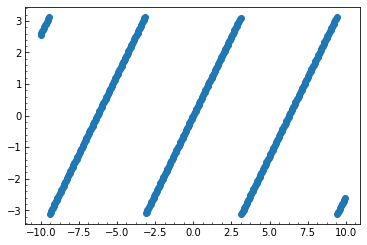

In [79]:
fig, ax = plt.subplots()
ax.plot(t, y, 'o')

## Strongly Correlated Gaussian target distribution (for testing HMC implementation)

### Define log density function of target distribution (potential energy function) $S(x)$

$$ S(\mathbf{x}) = \frac{-\frac{1}{2} (\mathbf{x} - \mathbf{\mu})^{T} \mathbf{\Sigma}^{-1}(\mathbf{x} - \mathbf{\mu})}{\sqrt{|\Sigma|}} $$ 


In [16]:
mu = np.zeros(2)
cov = np.array([[1., 0.95], [0.95, 1.]], dtype=np.float32)
cov_inv = np.linalg.inv(np.copy(cov))
def quadratic_gaussian(x):
    x_mu = x - mu
    return 0.5 * tf.reduce_sum(tf.transpose(x_mu) * cov_inv * x_mu)

def quadratic_gaussian_grad(x):
    return x

### Exact target distribution

In [18]:
mean = [0, 0]
cov = [[1., 0.95], [0.95, 1.]]
samples_x, samples_y = np.random.multivariate_normal(mean, cov, 1000).T

### Instantiate HMC object for sampling

In [19]:
step_size = 0.1
n_leapfrog_steps = 15
hmc = HMC(position_init=np.random.randn(2), 
          step_size=step_size,
          n_leapfrog_steps=n_leapfrog_steps,
          potential_fn=quadratic_gaussian,
          grad_potential_fn=grad_quad_gaussian)
          #grad_potential_fn=grad_quad_gaussian)

In [11]:
pos0 = [[-1., 1.]]
pos = [pos0]
vel = []
probs = []
pos1 = pos0

for i in range(500):
    #pos0 = pos[i-1]
    pos1, vel1, probs1 = hmc.apply_transition(pos1)
    pos.append(pos1)
    vel.append(vel1)
    probs.append(probs1)
pos = np.array(pos).reshape(len(pos), -1)
vel = np.array(vel)
probs = np.array(probs)

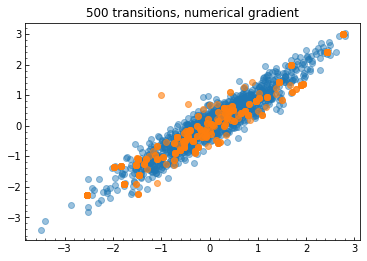

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()

### Look at the leapfrog integrator to tune hyperparameters

In [12]:
x0 = np.array([-1., 1.])
p0 = np.random.randn(*np.array(x0).shape)
x, p = x0, p0
x_arr = []
p_arr = []
for i in range(n_leapfrog_steps):
    lf_out = hmc._leapfrog_fn(x, p, i)
    x, p = lf_out
    x_arr.append(x)
    p_arr.append(p)
x_arr = np.array(x_arr)
p_arr = np.array(p_arr)

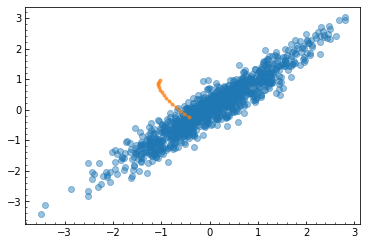

In [14]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(x_arr[:,0], x_arr[:,1], marker='.', ls='-', alpha=0.6)
plt.show()

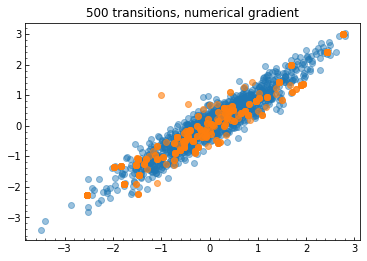

In [15]:
fig, ax = plt.subplots()
_ = ax.plot(samples_x, samples_y, marker='o', ls='', alpha=0.45)
_ = ax.plot(pos[:,0], pos[:,1], marker='o', ls='', alpha=0.6)
_ = ax.set_title('500 transitions, numerical gradient')
plt.show()